# Forecasting metrics: case 7

In this notebooks forecast metrics for all models fitted for the simulation case 7 are calculated and saved to a single file.

In [2]:
import os
import sys
import pickle

import tensorflow as tf
import pandas as pd
import numpy as np

src_path = os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd())))
sys.path.append(src_path)

from Metrics.metrics import get_model_metrics
from DataSimulation.utils import plot_fit
from Transformers.model import Forecaster


## Data

In [3]:
case = "case_7"
case_path = os.path.join(src_path, "Notebooks", "data_generation_and_models_fitting", case)

In [4]:
data = pd.read_csv(os.path.join(case_path, 'data.csv'), header=None)
data.head()

,0,1,2,3,4,5,6,7,8,9
0,231.0,234.0,8.0,7.0,3.0,6.0,8.0,863.0,1496.0,4851.0
1,255.0,260.0,7.0,5.0,5.0,5.0,8.0,931.0,1438.0,4849.0
2,244.0,238.0,5.0,4.0,6.0,6.0,7.0,871.0,1412.0,4808.0
3,240.0,229.0,3.0,8.0,6.0,6.0,5.0,882.0,1413.0,4781.0
4,209.0,258.0,7.0,7.0,6.0,5.0,7.0,885.0,1353.0,4796.0


In [5]:
test_size = 4*24
train_data = data.iloc[:-test_size, :].to_numpy()
test_data = data.iloc[-test_size:, :].to_numpy()
num_vars = train_data.shape[-1]
print(train_data.shape)
print(test_data.shape)

(904, 10)
(96, 10)


In [6]:
metrics = {}
metrics_statistics = {}

## Sarima model

In [7]:
with open(os.path.join(case_path, "sarima.pkl"), "rb") as file:
    sarima_model = pickle.load(file)

In [8]:
sarima_prediction = sarima_model.predict(test_size)

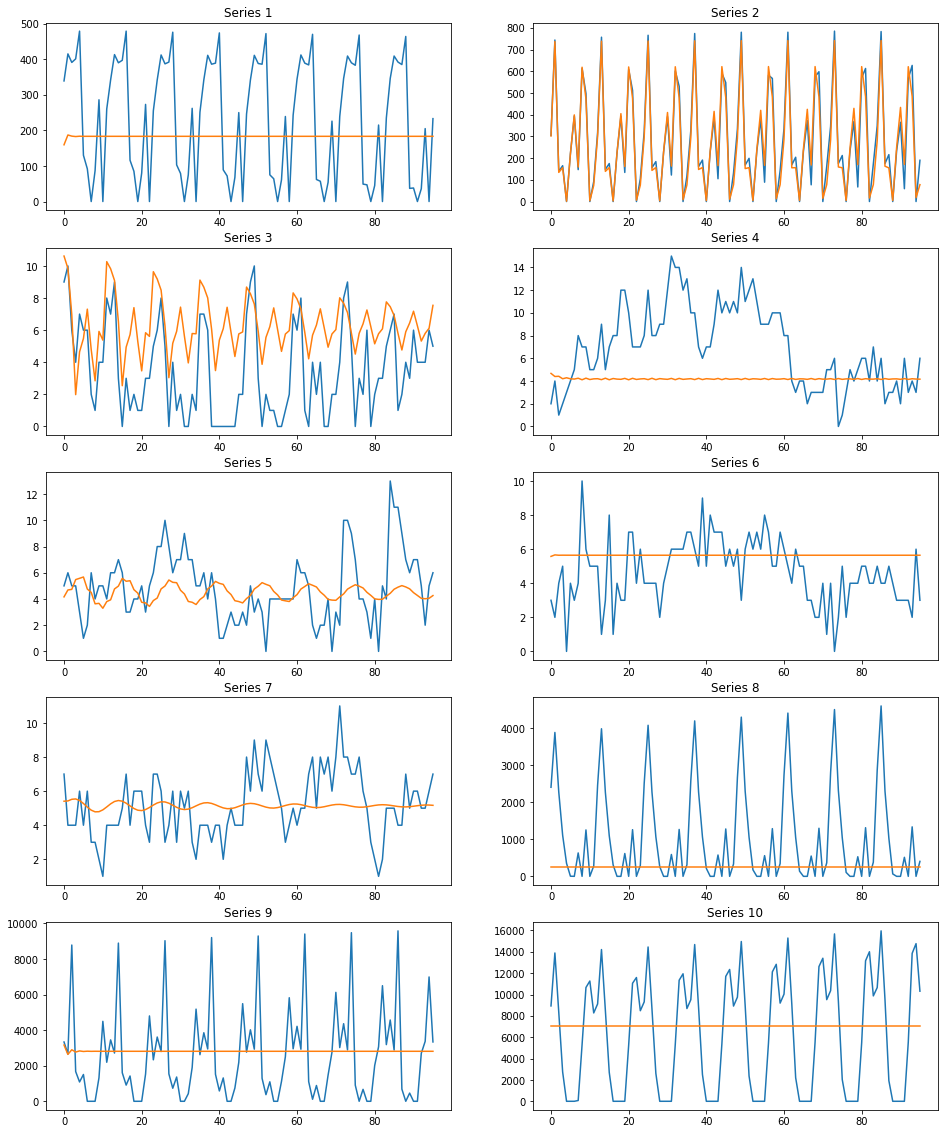

In [9]:
plot_fit(test_data, sarima_prediction, predicted=True, cols=2)

In [10]:
sarima_metrics, sarima_statistics = get_model_metrics(
    test_data=test_data,
    predicted_values=sarima_prediction,
    train_data=train_data,
    m=1,
    model_name="sarima",
    case=case
)
metrics.update(sarima_metrics)
metrics_statistics.update(sarima_statistics)

## Poisson Autoregression model

In [11]:
with open(os.path.join(case_path, "poisson_autoregression.pkl"), "rb") as file:
    poisson_ar_model = pickle.load(file)

In [12]:
poisson_ar_prediction = poisson_ar_model.predict(test_size)

c:\Users\User\Documents\Maestria\tesis_code\On_time_series_of_counts_forecast\PoissonAutoregression\PoissonAutoregression.py:425: RuntimeWarning: divide by zero encountered in divide
  self.y_pred = 1/np.exp(-nus_v)
c:\Users\User\Documents\Maestria\tesis_code\On_time_series_of_counts_forecast\PoissonAutoregression\PoissonAutoregression.py:425: RuntimeWarning: overflow encountered in divide
  self.y_pred = 1/np.exp(-nus_v)


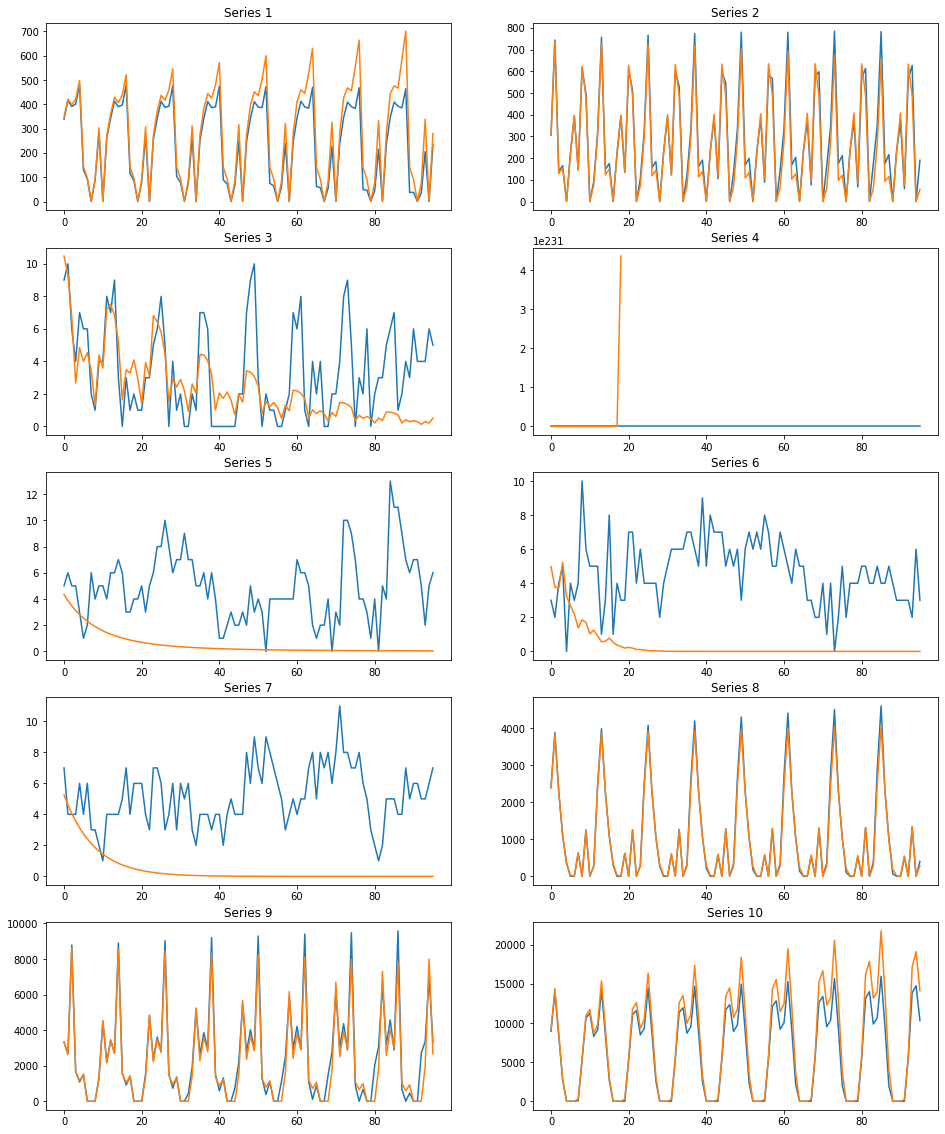

In [13]:
plot_fit(test_data, poisson_ar_prediction, predicted=True, cols=2)

In [14]:
p_ar_metrics, p_ar_statistics = get_model_metrics(
    test_data=test_data,
    predicted_values=poisson_ar_prediction,
    train_data=train_data,
    m=1,
    model_name="poisson_autorregression",
    case=case
)
metrics.update(p_ar_metrics)
metrics_statistics.update(p_ar_statistics)

c:\Users\User\Documents\Maestria\tesis_code\On_time_series_of_counts_forecast\Metrics\metrics.py:28: RuntimeWarning: invalid value encountered in divide
  return 2*np.mean(error/norm, axis=0)*100
c:\Users\User\Python\Environments\tensorflow_3.9\lib\site-packages\numpy\core\_methods.py:236: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


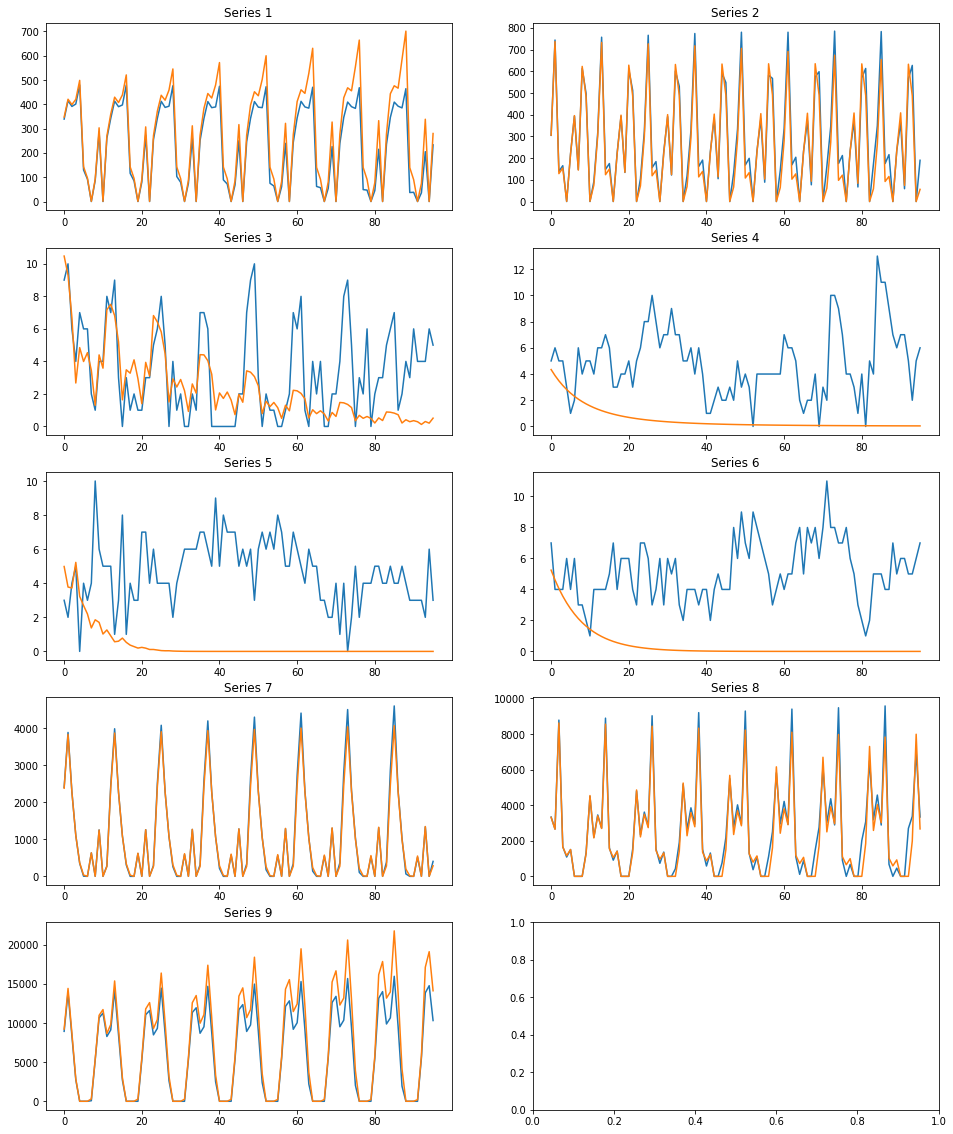

In [15]:
selector = [x for x in range(test_data.shape[1]) if x not in [3]]
plot_fit(test_data[:,selector], poisson_ar_prediction[:,selector], predicted=True, cols=2)

In [16]:
p_ar_metrics, p_ar_statistics = get_model_metrics(
    test_data=test_data[:,selector],
    predicted_values=poisson_ar_prediction[:,selector],
    train_data=train_data[:,selector],
    m=1,
    model_name="poisson_autorregression_adjusted",
    case=case
)
metrics.update(p_ar_metrics)
metrics_statistics.update(p_ar_statistics)

## Recurrent Neural Network

The model summary in the "rnn_fit.ipynb" allows to know that the best model uses a 24 timesteps input

In [17]:
input_steps = 24


In [18]:
with open(os.path.join(case_path, "rnn_scaler.pkl"), "rb") as file:
    rnn_scaler = pickle.load(file)

In [19]:
scaled_data = rnn_scaler.transform(train_data[-input_steps:]).reshape((1,input_steps,-1))

In [20]:
rnn_model = tf.keras.models.load_model(os.path.join(case_path, "rnn.h5"))

In [21]:
initial_prediction = rnn_model.predict(scaled_data)
current_prediction = initial_prediction
rnn_prediction = current_prediction
for _ in range(3):
    current_prediction = rnn_model.predict(current_prediction)
    rnn_prediction = np.concatenate([rnn_prediction, current_prediction], axis=0)

rnn_prediction = rnn_prediction.reshape((-1,num_vars))

1/1 [==============================] - 0s 20ms/step


In [22]:
rnn_prediction = rnn_scaler.inverse_transform(rnn_prediction)

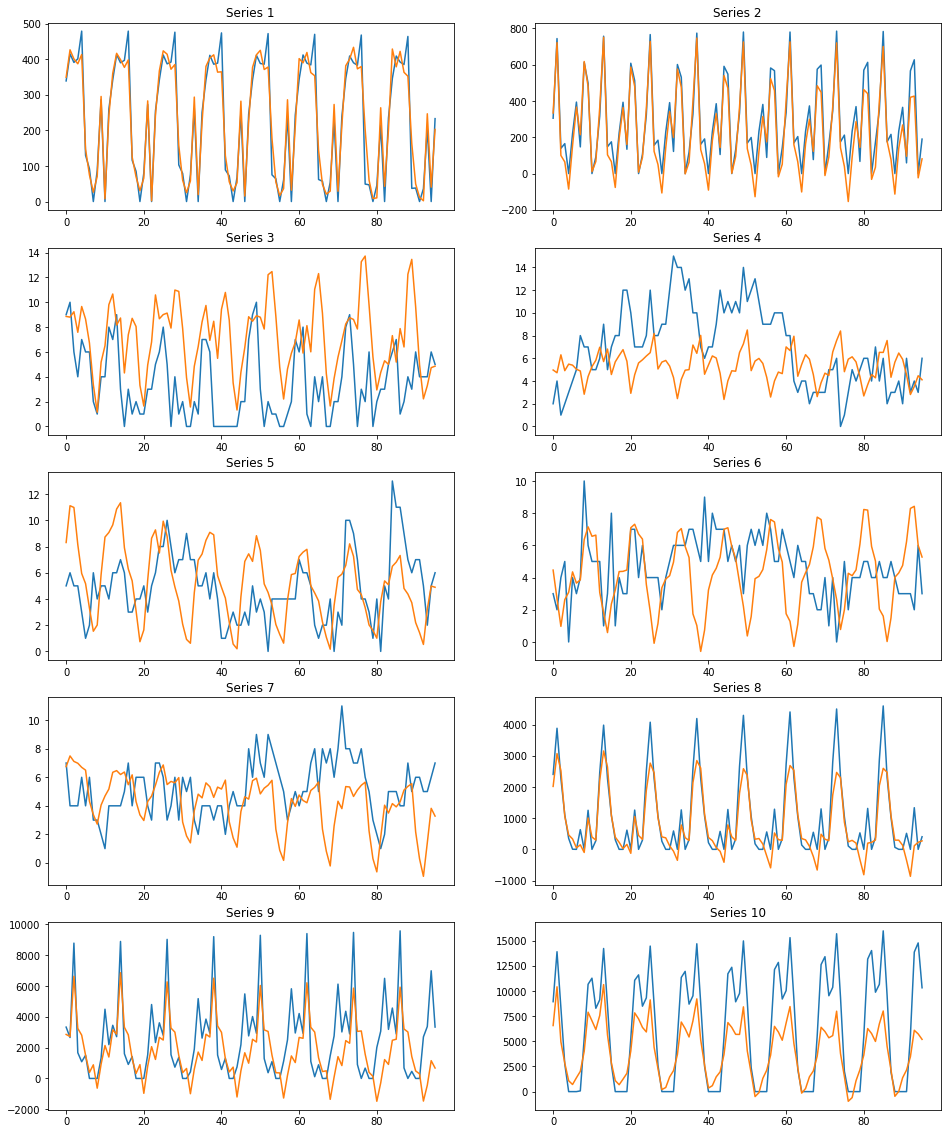

In [23]:
plot_fit(test_data, rnn_prediction, predicted=True, cols=2)

In [24]:
rnn_metrics, rnn_statistics = get_model_metrics(
    test_data=test_data,
    predicted_values=rnn_prediction,
    train_data=train_data,
    m=1,
    model_name="recurrent_neural_network",
    case=case
)
metrics.update(rnn_metrics)
metrics_statistics.update(rnn_statistics)

## Transformer model

In [25]:
with open(os.path.join(case_path, "transformer_scaler.pkl"), "rb") as file:
    transformer_scaler = pickle.load(file)

In [26]:
transformer_model = tf.keras.models.load_model(os.path.join(case_path, "transformer.tf"))

In [27]:
forecaster = Forecaster(transformer_scaler, transformer_model)

In [28]:
t_input_steps = 24
inputs = train_data[-t_input_steps:]

In [29]:
transformer_prediction = forecaster(inputs=inputs, steps=24)

In [30]:
inputs = train_data[-t_input_steps:]
initial_prediction = forecaster(inputs=inputs, steps=24)
current_prediction = initial_prediction
transformer_prediction = current_prediction
for _ in range(3):
    current_prediction =forecaster(inputs=current_prediction, steps=24)
    transformer_prediction = np.concatenate([transformer_prediction, current_prediction], axis=0)

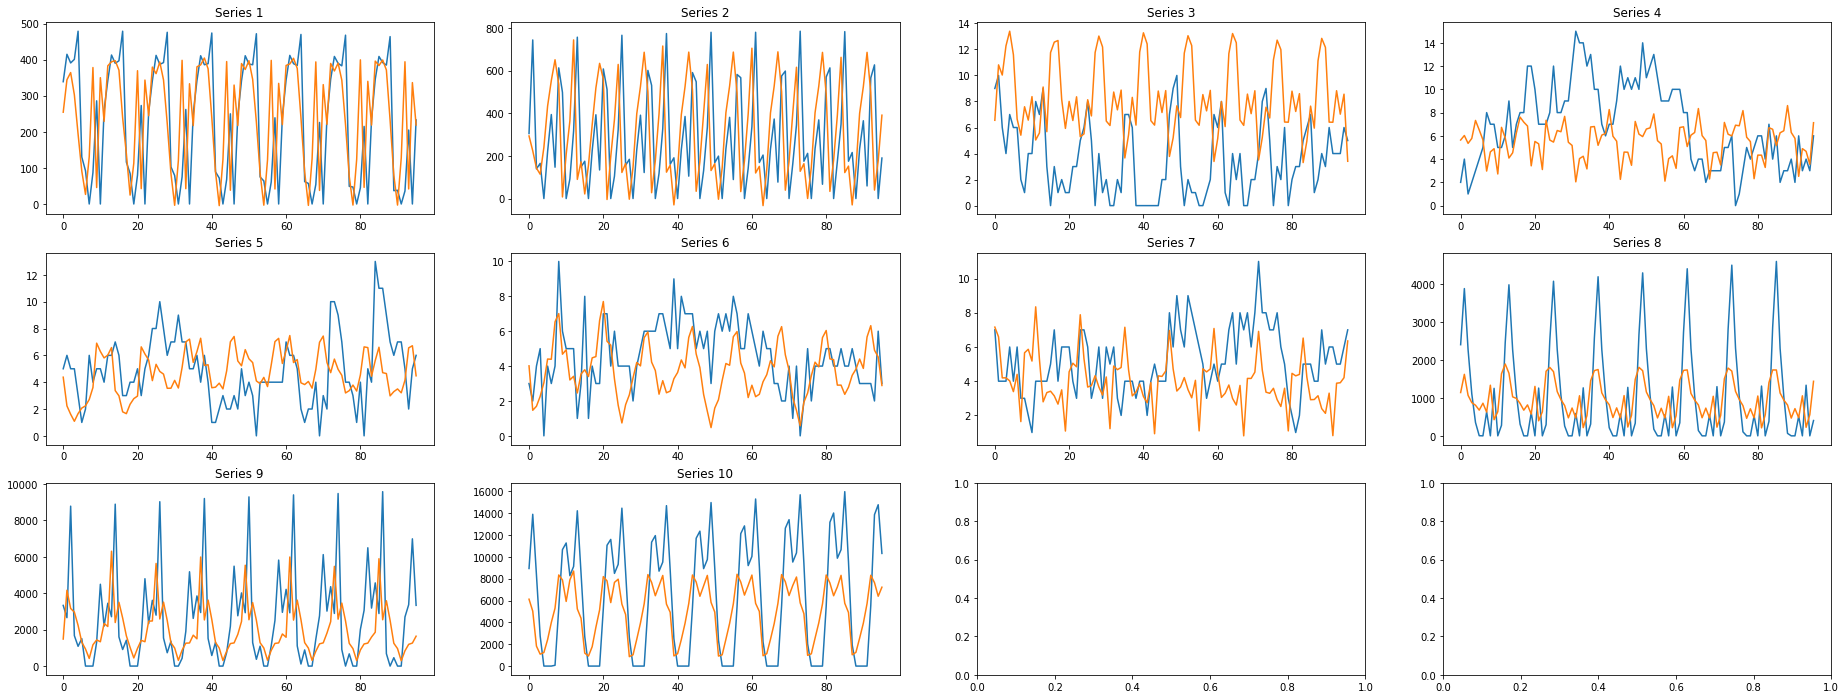

In [31]:
plot_fit(test_data, transformer_prediction, predicted=True, cols=4)

In [32]:
transformer_metrics, transformer_statistics = get_model_metrics(
    test_data=test_data,
    predicted_values=transformer_prediction,
    train_data=train_data,
    m=1,
    model_name="transformer",
    case=case
)
metrics.update(transformer_metrics)
metrics_statistics.update(transformer_statistics)

## Metrics results

In [33]:
pd.DataFrame(metrics_statistics)

sarima           poisson_autorregression            \
                  sMAPE      MASE                   sMAPE      MASE   
case_7 mean   73.348178  1.875262                     NaN       inf   
       sd     32.480146  1.178695                     NaN       NaN   
       min    31.803036  0.203566                     NaN  0.163681   
       max   141.923718  4.636267                     NaN       inf   

            poisson_autorregression_adjusted            \
                                       sMAPE      MASE   
case_7 mean                       104.015213  1.374055   
       sd                          49.712231  1.211885   
       min                         50.250207  0.163681   
       max                        176.890883  3.359722   

            recurrent_neural_network           transformer            
                               sMAPE      MASE       sMAPE      MASE  
case_7 mean                74.838556  1.535599   82.893007  2.002624  
       sd                  21.134617  0.723569   25.623316  0.688088  
       min                 51.645637  0.327588   50.268733  1.202988  
       max                107.916911  2.724104  116.846729  3.518056

In [34]:
with open("metrics.pkl", "wb") as outfile:
    pickle.dump(metrics, outfile)

with open("statistics.pkl", "wb") as outfile:
    pickle.dump(metrics_statistics, outfile)